In [2]:
#Python > 3.5 version is required
import sys
assert sys.version_info>=(3,5)

##We will be using Sklearn for our project and hence we would need a version >=0.20
import sklearn
sklearn.__version__>="0.20"

True

In [3]:
#We mute the warnings
import warnings as w
w.filterwarnings('ignore')
w.filterwarnings('always')
w.filterwarnings("ignore", category=DeprecationWarning)

### Importing the Relevant Libraries

In [37]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.sparse import hstack, csr_matrix
import random
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob

##### We read the data 

In [5]:
train = pd.read_csv(r'dataset/train_file.csv',sep=',')
test = pd.read_csv(r'dataset/test_file.csv',sep=',')

In [6]:
train.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,02-04-2002 00:00,-1,-1,-1,0.000000,-0.053300
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,20-09-2008 00:00,-1,-1,-1,0.208333,-0.156386
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,28-01-2012 00:00,-1,-1,-1,-0.425210,0.139754
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,01-03-2015 00:06,-1,-1,-1,0.000000,0.026064
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,01-03-2015 00:11,-1,-1,-1,0.000000,0.141084


# EDA & DATA CLEANING

### Checking for the null values

In [7]:
print(train.isnull().sum())
print('*'*100)
print(test.isnull().sum())

IDLink                 0
Title                  0
Headline               0
Source               175
Topic                  0
PublishDate            0
Facebook               0
GooglePlus             0
LinkedIn               0
SentimentTitle         0
SentimentHeadline      0
dtype: int64
****************************************************************************************************
IDLink           0
Title            0
Headline         0
Source         101
Topic            0
PublishDate      0
Facebook         0
GooglePlus       0
LinkedIn         0
dtype: int64


__Hence we see that only the source column has null values. So we tackle this column in both the data sets. We see the top 3 sources and fill the null values with the source that has the maximum frequency or the model of the column__

In [8]:
topSources = train['Source'].value_counts()[:3]
print(topSources)
print('\nWe could take the null values and fill it with the mode of the column that is Bloomberg.')


Bloomberg    992
Reuters      763
ABC News     645
Name: Source, dtype: int64

We could take the null values and fill it with the mode of the column that is Bloomberg.


In [9]:
train['Source'] = train['Source'].fillna('Bloomberg')
print(f'Null values in the training data set -  {train.Source.isnull().sum()}')
test['Source'] = test['Source'].fillna('Bloomberg')
print(f'Null values in the test data set- {test.Source.isnull().sum()}')

Null values in the training data set -  0
Null values in the test data set- 0


### Target variables

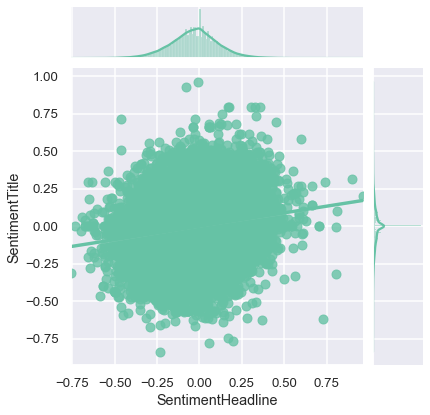

In [10]:
sns.set(style='darkgrid',palette='Set2')
sns.set_context("talk", font_scale=0.8)
ax = sns.jointplot(x=train.SentimentHeadline,y=train.SentimentTitle,data=train,kind='reg')
sns.set(rc={'figure.figsize':(20,20)})
plt.show()

* __Hence we see that both the target variables do not have much variablity amongst each other and the strenth of relationship is quite strong.__
* __Secondly, the marginal distributions show that both the variables are nearly normal.__

### Topic Segregation

economy      36.626618
obama        30.245655
microsoft    23.083387
palestine    10.044340
Name: Topic, dtype: float64


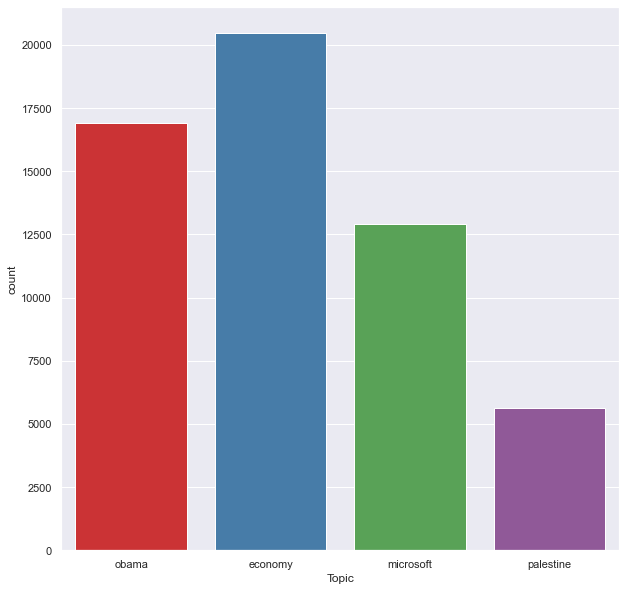

In [11]:
plt.figure(figsize=(10,10))
sns.set_context("talk", font_scale=0.8)
sns.set(style='darkgrid',palette='Set1')
sns.countplot(x='Topic',data=train)
print(train.Topic.value_counts(normalize=True)*100)
plt.show()

___Hence we observe that the dominant topics have been `Economic`& `Obama`, however, `palestine` has been the least talked about topics in the news items___

## Finding correlations

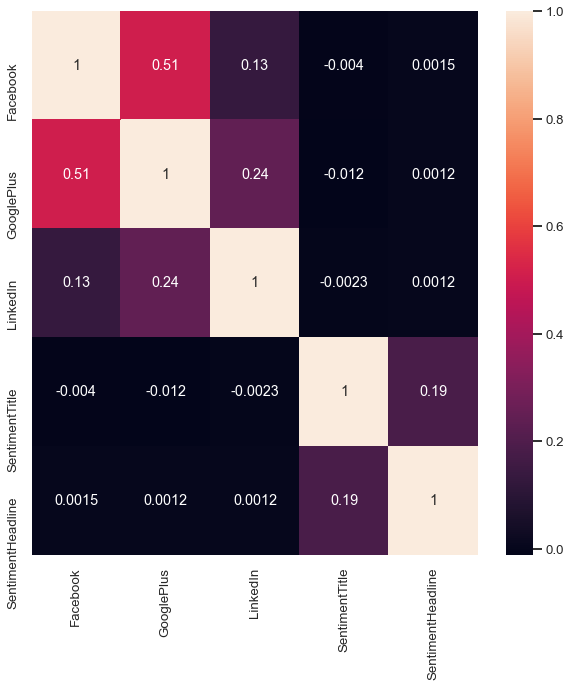

In [12]:
corrColumns = train.iloc[:,6:]
corr = corrColumns.corr()
plt.figure(figsize=(10,10))
sns.set_context("talk", font_scale=0.8)
sns.heatmap(corr,annot=True)
plt.show()

#### `Hence the Pearson correlation coefficients amongst the columns is fairly low and does not raise any alarm with the highest being between GooglePlus and Facebook which is understandable as if the news item has a particular sentiment over a specific Social media platform then it is bound to follow the similar trend on the other platforms as well`

### Now we look into the textual columns

In [13]:
train.dtypes

IDLink                object
Title                 object
Headline              object
Source                object
Topic                 object
PublishDate           object
Facebook               int64
GooglePlus             int64
LinkedIn               int64
SentimentTitle       float64
SentimentHeadline    float64
dtype: object

#### IDLinks are unique so would not help much in modelling. Also the PublishDate is of date type

In [14]:
## So we have 3 textual columns.

train['txt_title'] = train.Title + ' ' + train.Source + ' ' + train.Topic
test['txt_title'] = test.Title + ' ' + test.Source + ' ' + test.Topic

train['txt_headline'] = train.Headline + ' ' + train.Source + ' ' + train.Topic
test['txt_headline'] = test.Headline + ' ' + test.Source + ' ' + test.Topic

In [15]:
print(train.txt_headline[1])
print(train.txt_title[1])

Tim Haywood, investment director business-unit head for fixed income at Gam, discusses the China beige book and the state of the economy. Bloomberg economy
A Look at the Health of the Chinese Economy Bloomberg economy


In [16]:
train.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline,txt_title,txt_headline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,02-04-2002 00:00,-1,-1,-1,0.000000,-0.053300,Obama Lays Wreath at Arlington National Cemete...,Obama Lays Wreath at Arlington National Cemete...
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,20-09-2008 00:00,-1,-1,-1,0.208333,-0.156386,A Look at the Health of the Chinese Economy Bl...,"Tim Haywood, investment director business-unit..."
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,28-01-2012 00:00,-1,-1,-1,-0.425210,0.139754,Nouriel Roubini: Global Economy Not Back to 20...,"Nouriel Roubini, NYU professor and chairman at..."
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,01-03-2015 00:06,-1,-1,-1,0.000000,0.026064,Finland GDP Expands In Q4 RTT News economy,Finland's economy expanded marginally in the t...
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,01-03-2015 00:11,-1,-1,-1,0.000000,0.141084,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...


### TEXT PREPROCESSING

In [17]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

In [18]:
stop_w = set(stopwords.words('english'))

## We create a function

def cleanFunc(t):
    puncFree = remove_punctuation(t)
    tokenize = word_tokenize(puncFree)
    filtered_text = ' '.join([w.lower() for w in tokenize if w.lower() not in stop_w])
    filtered_text = filtered_text.replace(r"[^a-zA-Z]+", '') #remove all characters except the ones mentioned
    Nos_filter = re.sub(r'\b\d+\b', '', filtered_text) #removing the digits
    return Nos_filter
    

In [19]:
train['txt_title'] = [cleanFunc(x) for x in train['txt_title']]

#### We now check if the things have worked. Seems like they have, so now we make changes in the test data sets and the 'Headline' columns as well.

In [20]:
train.txt_title[1]

'look health chinese economy bloomberg economy'

In [21]:
test['txt_title']=[cleanFunc(x) for x in test['txt_title']]

##Changing the headline column
train['txt_headline'] = [cleanFunc(x) for x in train['txt_headline']]
test['txt_headline'] = [cleanFunc(x) for x in test['txt_headline']]

### Feature Extraction - Word Embeddings

In [22]:
## We instantiate the method here
vectorizer = TfidfVectorizer(use_idf=True)

train_title_vect = vectorizer.fit_transform(train['txt_title'])
test_title_vect = vectorizer.transform(test['txt_title'])

vectorizer1 = TfidfVectorizer()

train_headline_vect = vectorizer1.fit_transform(train['txt_headline'])
test_headline_vect = vectorizer1.transform(test['txt_headline'])

In [23]:
train.head(2)

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline,txt_title,txt_headline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,02-04-2002 00:00,-1,-1,-1,0.000000,-0.053300,obama lays wreath arlington national cemetery ...,obama lays wreath arlington national cemetery ...
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,20-09-2008 00:00,-1,-1,-1,0.208333,-0.156386,look health chinese economy bloomberg economy,tim haywood investment director businessunit h...


### Encoding categorical columns

In [24]:
le = LabelEncoder()

train['Topic'] = le.fit_transform(train['Topic'])
test['Topic'] = le.transform(test['Topic'])

In [25]:
sources = train['Source'].to_list() + test['Source'].to_list()
sources_le = le.fit_transform(sources)
train['Source'] = le.transform(train['Source'])
test['Source'] = le.transform(test['Source'])

### We convert the sparse matrix through the Count vectorizer method. Here each of the unique words will be converted as a separate column.

In [26]:
c_vect = CountVectorizer()

word_count = c_vect.fit_transform(train['txt_title'])
feature_names = c_vect.get_feature_names_out()
output = pd.DataFrame.sparse.from_spmatrix(train_title_vect,columns=feature_names)

In [27]:
output.head(2)

,06pc,09pc,100000signature,100b,100billion,100bln,100bn,100gig,100k,100m,...,zum,zuma,zumas,zumba,zunar,zune,zurbruegg,zvezda,zwane,zyoud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Splitting the Title columns

In [28]:
x_train_t, x_test_t ,y_train_t ,y_test_t = train_test_split(train_title_vect,train['SentimentTitle'],test_size=0.2,shuffle=True)

### Splitting the Headline columns

In [36]:
x_train_h, x_test_h, y_train_h, y_test_h = train_test_split(train_headline_vect,train['SentimentHeadline'],test_size=0.2,shuffle=True)

### We will train the XGBREGRESSOR for making the predictions

In [54]:
xg1 = XGBRegressor()

In [55]:
xg1.fit(x_train_t,y_train_t)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [56]:
y_pred_t1 = xg1.predict(x_test_t)
er_t1 = mean_absolute_error(y_test_t,y_pred_t1)

### MAE for Title

In [57]:
1-er_t1

0.9265128033017543

In [58]:
xg2 = XGBRegressor()
xg2.fit(x_train_h,y_train_h)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [59]:
y_pred_h1 = xg2.predict(x_test_h)
er_h1 = mean_absolute_error(y_test_h,y_pred_h1)

### MAE for Headline

In [60]:
1-er_h1

0.9149356196522921

## Evaluation Criteria

In [61]:
max(0,(1-(0.4*er_t1+0.6*er_h1)))

0.919566493112077

In [62]:
pred_t1 = xg1.predict(test_title_vect)

In [63]:
pred_h1 = xg2.predict(test_headline_vect)

In [64]:
submission1 = pd.DataFrame()
submission1['IDLink'] = test['IDLink']
submission1['SentimentTitle']=pred_t1
submission1['SentimentHeadline']=pred_h1
submission1.head()

,IDLink,SentimentTitle,SentimentHeadline
0,tFrqIR6Chj,0.115135,-0.083979
1,DVAaGErjlF,-0.092933,0.011729
2,OT9UIZm5M2,-0.004674,-0.095737
3,lflGp3q2Fj,0.003788,-0.050958
4,zDYG0SoovZ,-0.064611,0.037427


In [65]:
submission1.to_csv('Submission_1.csv',index=False)

__This was a base line model. Now we consider some more features in the data frame and fit another model in order to enhance the accuracy__

### Now we shall consider the scores from the social media sources. Note that the Publish date would not help us in imporving or predictive accuracy and IDLinks as well (being unique identities) - hence we would not consider them in our modelling or training of the model.

##### We start with scaling the columns in order to make them lie in the similar ranges and avoid redundant predictions henceforth.

In [30]:
scaler = StandardScaler()

columns = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn']

for col in columns:
    train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))
    test[col] = scaler.transform(test[col].values.reshape(-1, 1))

##### Updating the training and test data sets

In [32]:
train_upd = train[columns]
test_upd = test[columns]

In [34]:
##For the variable title

train_title = hstack([train_title_vect,csr_matrix(train_upd.values)])
test_title = hstack([test_title_vect,csr_matrix(test_upd.values)])
y_title = train['SentimentTitle']

##For the variable headline

train_headline = hstack([train_headline_vect,csr_matrix(train_upd.values)])
test_headline = hstack([test_headline_vect,csr_matrix(test_upd.values)])
y_headline = train['SentimentHeadline']

### Now we train the Light GBM regressors for the predictions of both our target variables

In [39]:
x_train, x_test, y_train, y_test = train_test_split(train_title,y_title,test_size=0.20)

lgbm1 = LGBMRegressor()
lgbm1.fit(x_train,y_train)

LGBMRegressor()

In [42]:
y_pred_t2 = lgbm1.predict(x_test)
mae_t = mean_absolute_error(y_test,y_pred_t2)
1-mae_t

0.9282475805985916

In [43]:
## For headline

x_train, x_test, y_train, y_test = train_test_split(train_headline,y_headline,test_size=0.20)

lgbm2 = LGBMRegressor()
lgbm2.fit(x_train,y_train)

y_pred_h2 = lgbm2.predict(x_test)
mae_h = mean_absolute_error(y_test,y_pred_h2)
1-mae_h

0.9163316169248736

## Evaluation Criteria

In [44]:
max(0,(1-(0.4*mae_t+0.6*mae_h)))

0.9210980023943608

In [45]:
final_pred_t = lgbm1.predict(test_title)
final_pred_h = lgbm2.predict(test_headline)

c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\lightgbm\basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\lightgbm\basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


In [47]:
submission2 = pd.DataFrame()
submission2['IDLink'] = test['IDLink']
submission2['SentimentTitle']=final_pred_t
submission2['SentimentHeadline']=final_pred_h
submission2.head()

,IDLink,SentimentTitle,SentimentHeadline
0,tFrqIR6Chj,0.120234,-0.084702
1,DVAaGErjlF,-0.119361,0.010657
2,OT9UIZm5M2,-0.003612,-0.085056
3,lflGp3q2Fj,0.091626,-0.000708
4,zDYG0SoovZ,-0.009191,0.044445


In [48]:
submission2.to_csv('Submission_final.csv',index=False)